In [17]:
import time
import numpy as np
import numba as nb
from timeit import timeit

In [37]:
@nb.jit(nopython=True, parallel=True)
def test(Nsteps, out, rng_seeds):
    for i in nb.prange(out.shape[0]):
        np.random.seed(rng_seeds[i])
        for step in range(Nsteps):
            out[i] += np.random.standard_normal()
            out[i] += np.random.standard_normal()

In [38]:
N_steps = 10_000_000
N_particles = 10

In [43]:
seed=1
np.random.seed(seed)
rng_seeds = np.random.randint(np.iinfo(np.uint32).max, size=N_particles, dtype=np.uint32)
out = np.zeros(N_particles)
test(N_steps, out, rng_seeds) # warmup
N_loops = 5
t0 = time.time_ns()
for _ in range(N_loops):
    rng_seeds = np.random.randint(np.iinfo(np.uint32).max, size=N_particles, dtype=np.uint32)
    test(N_steps, out, rng_seeds)
delta_t = (time.time_ns() - t0)/N_loops
print(f'{delta_t/N_steps/N_particles:.2f} ns/dt/p')
out[0]

22.28 ns/dt/p


7771.671936225897

In [41]:
out[0]

5608.852327314961

In [46]:
np.random.SeedSequence().entropy

66432083429865109102651919992550842517

In [52]:
np.random.SeedSequence().entropy%(2**32-1)

2714689720

In [55]:
seed = np.random.SeedSequence().entropy%(2**32-1)
np.random.seed(seed)
np.random.uniform()

0.526017278631049

In [52]:
out = np.zeros(N_particles, dtype='float32')
test_f32(N_steps, out) # warmup
N_loops = 5
t0 = time.time_ns()
for _ in range(N_loops):
    test_f32(N_steps, out)
delta_t = (time.time_ns() - t0)/N_loops
print(f'{delta_t/N_steps/N_particles*N_THREADS:.2f} ns/dt/p/cores')

61.34 ns/dt/p/cores


In [ ]:
randomgen.generator.standard_normal()

In [52]:
test.parallel_diagnostics(level=1)

 
 Parallel Accelerator Optimizing:  Function test, <ipython-
input-42-b98cb058667e> (1)  


Parallel loop listing for  Function test, <ipython-input-42-b98cb058667e> (1) 
------------------------------------------------|loop #ID
@nb.jit(nopython=True, parallel=True)           | 
def test(Nsteps, out):                          | 
    for i in nb.prange(out.shape[0]):-----------| #4
        np.random.seed(i)                       | 
        for step in range(Nsteps):              | 
            out[i] += np.random.uniform(0,1)    | 
------------------------------ After Optimisation ------------------------------
Parallel structure is already optimal.
--------------------------------------------------------------------------------
--------------------------------------------------------------------------------
 


In [57]:
import randomgen

ModuleNotFoundError: No module named 'randomgen'

In [54]:
from numba import cuda

In [55]:
cuda.detect()

Found 1 CUDA devices
id 0    b'NVIDIA GeForce GTX 1050 Ti with Max-Q Design'                              [SUPPORTED]
                      compute capability: 6.1
                           pci device id: 0
                              pci bus id: 2
Summary:
	1/1 devices are supported


True

In [56]:
cuda.is_available()

True

In [1]:
from brownpy import gpu_sim
from brownpy.gpu_sim import Universe
import brownpy.topology as Top
from brownpy.utils import prefix, unwrap
import matplotlib.pyplot as plt
# https://matplotlib.org/stable/gallery/axes_grid1/inset_locator_demo.html
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import h5py
import numpy as np
from threading import Thread
from pathlib import Path
import time
import pandas as pd
from tqdm.notebook import tqdm
plt.style.use('default')
import cupy as cp

In [18]:
seed = 1
# Diffusion coefficient
D = 1.5E-4 # A²/fs  (1.5E-9 m²/s) - Diffusion coefficient

"""
┃         ┃   ┃         ┃      ↑  
┃         ┃   ┃         ┃      │
┃         ┗━━━┛         ┃      │
┃                       ┃ ↕ Hc │ 2 H
┃         ┏━━━┓         ┃      │
┃         ┃   ┃         ┃      │
┃         ┃   ┃         ┃      ↓
 ←-------→ ←-→ ←-------→
     L      Lc     L
"""
# Conversion into my notation
Hc = 1E2 # A (10nm) - Channel width
L = 250*Hc # Channel depth
H_factor = 1
H = H_factor*Hc # Distance between channel
ar_factor = 100
Lc = ar_factor*Hc # Channel length

# Timestep 
dt = int(0.05*Hc**2/D)
N = 2*1024
print(f'dt = {dt:.2e} fs = {prefix(dt*1E-15)}s')

Nsteps = int(1.5*1E6/0.05) 
print(f"Number of steps : {Nsteps:.2e} = {prefix(dt*Nsteps*1E-15)}s")


top = Top.ElasticChannel2(Hc=Hc, Lc=Lc, 
                          H=H, L=L)
u=Universe(N=N, top=top, D=D, dt=dt,
           output_path=f'./4/channel/{H_factor}_{ar_factor}',
           overwrite=True, seed=seed)

dt = 3.33e+06 fs = 3.33 ns
Number of steps : 3.00e+07 = 100 ms


In [19]:
u.pos[0]

array([5591.081  ,   90.09274], dtype=float32)

In [20]:
#GPU
u.run(Nsteps//100, target='cpu', seed=seed)

100%|██████████| 300000/300000 [00:18<00:00, 15982.88it/s, total=1e+03 µs]

With 2048 particles
------------------------------------------
CPU time per step and per particles:
Total: 30.6 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 9.17  s


In [21]:
u.pos[0]

array([11408.05    ,    77.026375], dtype=float32)

In [22]:
u.engine.parallel_diagnostics()

 
 Parallel Accelerator Optimizing:  Function 
Universe._gen_engine.<locals>.engine, 
c:\users\monet\documents\job\2021_postdoc\code\brownpy\brownpy\gpu_sim.py (402)
  


Parallel loop listing for  Function Universe._gen_engine.<locals>.engine, c:\users\monet\documents\job\2021_postdoc\code\brownpy\brownpy\gpu_sim.py (402) 
-----------------------------------------------------------------------------------------------------------------------------------|loop #ID
      @nb.njit(parallel=True)                                                                                                      | 
      def engine(r0, t0, N_steps, inside, seeds, trajectory, freq_dumps,                                                           | 
                _internal_states):                                                                                                 | 
        """Physical engine function compiled in CUDA to simulate pure brownian                                                     

In [23]:
u.f

/date = Created Wed Sep  8 18:49:56 2021
/dt = 3333333
/dtype = float32
/ndim = 2
/source = Created with BM_cuda
/units = real
/version = 0.1.0b
/geometry/H = 100.0
/geometry/Hc = 100.0
/geometry/L = 25000.0
/geometry/Lc = 10000.0
/geometry/name = ElasticChannel2
/geometry/version = 0.0.2
/particles/N = 2048
/particles/initial_seed = 1
/particles/0/D = 0.00015
/particles/0/type = 0
/particles/initial_pos - float32((2048, 2))
/particles/type - uint8((2048,))
/run/N_runs = 0
/run/0/N_steps = 300000
/run/0/seed = 1
/run/0/status = COMPLETED
/run/0/step_f = 300000
/run/0/step_i = 0
/run/0/target = cpu
/run/0/regions/left - uint16((300000,))
/run/0/regions/right - uint16((300000,))

In [7]:
#CPU
u.run(Nsteps//10, target='cpu', regions=[])

100%|██████████| 3000000/3000000 [02:18<00:00, 21609.98it/s, total=10 ms]

With 2048 particles
------------------------------------------
CPU time per step and per particles:
Total: 22.6 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 6.78  s


In [8]:
#GPU
u.run(Nsteps//100, target='cpu', freq_dumps=100)

100%|██████████| 300000/300000 [00:16<00:00, 17796.90it/s, total=1e+03 µs]

With 2048 particles
------------------------------------------
CPU time per step and per particles:
Total: 27.4 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 8.23  s


In [12]:
traj = u.f['/run/5/trajectory']

(-29985.984375, -7319.5009765625)

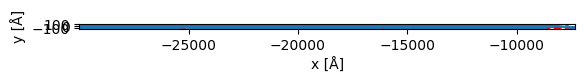

In [16]:
u.top.plot()
plt.plot(traj[0,0,:], traj[0,1,:])
# plt.xlim(traj[0,0,:].min(), traj[0,0,:].max())
# plt.aspect()

In [15]:
t0 = time.perf_counter_ns()
time.sleep(1)
time.perf_counter_ns() - t0

1005665600

In [12]:
time.perf_counter_ns()

12284586829900

In [5]:
#GPU
u.run(Nsteps//100, freq_dumps=100)

100%|██████████| 300000/300000 [00:02<00:00, 100366.95it/s, total=3 ms]

With 2048 particles
------------------------------------------
GPU time per step and per particles:
Allocation: 39.9 fs
Engine: 4.66 ns
Transfert to RAM: 34.5 ps
Total: 4.69 ns
------------------------------------------
CPU time per step and per particles:
Total: 4.87 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 1.46  s


In [4]:
#CPU
u.run(Nsteps//100)

100%|██████████| 300000/300000 [00:14<00:00, 20960.32it/s, total=2 ms]

With 2048 particles
------------------------------------------
CPU time per step and per particles:
Total: 23.3 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 6.99  s


In [6]:
#CPU
u.run(10000, freq_dumps=100)

100%|██████████| 10000/10000 [00:00<00:00, 15250.23it/s, total=2.04 ms]

With 2048 particles
------------------------------------------
CPU time per step and per particles:
Total: 32.2 ns
------------------------------------------
For a timestep of 3.33 ns
To simulate the trajectory of 1 particle during 1 s, we need 9.65  s


In [13]:
from pathlib import PosixPath

In [16]:
items_path  = ('run/0/trajectory').split('/')

In [19]:
'/'.join(items_path[:-1])

'run/0'

In [14]:
str(PurePath('run/0/trajectory').parent)

NotImplementedError: cannot instantiate 'PosixPath' on your system

In [7]:
data['trajectory'].shape

(2048, 2, 10)

In [4]:
f = h5py.File(u.output_path, 'r')

In [8]:
f['run/0/regions/left']

<HDF5 dataset "left": shape (300000,), type "<u2">

In [1]:
gpu_sim._GPU_COMPUTATION = False

NameError: name 'gpu_sim' is not defined

In [7]:
Universe._GPU_COMPUTATION

AttributeError: type object 'Universe' has no attribute '_GPU_COMPUTATION'

In [5]:
_GPU_COMPUTATION

NameError: name '_GPU_COMPUTATION' is not defined